In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from matplotlib.offsetbox import AnchoredText
from IPython.display import display, Audio

from dssplib import plot_time_domain_signal, stft, plot_stft

plt.rcParams['figure.figsize'] = (15.0, 4.0)

# Short Term Fourier Transform

The Fast Fourier transform is a good way to describe time-domain signals in the frequency domain. However, there are multiple drawbacks in practice:

- The Duration to be taken needs to be very long if long time-domain signals are to be analysed. This increases the  algorithm runtime and the delay.
- The Duration and the frequency resolution are hard-coupled. For a very long signal, the frequency resolution is usually unneccesary good.
- The time-information is completely lost: The spectrum does only show which frequenies the signal contains by a certain amount, but not when they were present. This is not suitable for non-stationary signals where everything is about when something happens.

These drawbacks can be overcome by taking overlapping short frames of the time domain sequence and transforming them into the frequency domain. This can be imagined as multiplying the sequence with a shorter sliding rectangular window of duration $M$:

\begin{align}
    x_m(n + m \cdot B) = x(n + m \cdot B) \cdot \mathrm{rect}_M (n)
\end{align}

Here, $B$ is the block shift which is usually a fraction of $M$.

In practice, the rectangular window is replaced by a carefully chosen window function:

\begin{align}
    x_m(n + m\cdot B) = x(n + m \cdot B) \cdot w_M(n)
\end{align}

The reasons for this change were discussed in the lecture:
- The leakage effect leads to **ghosting** (i.e. frequency components appear where nothing should be).
- The non-vanishing width of the window's main lobe in the spectral domain causes **blurring** (i.e. the frequency "lines" in the STFT are widened through the main lobe).

A good in-depth discussion of the Short Term Fourier Transform is given in the [Springer Handbook of Speech Processing by Benesty et al.](https://books.google.de/books?id=Slg10ekZBkAC&dq=handbook%20of%20speech%20processing%20stft&pg=PA229).

Now, a  DFT of the cut-out sequence of length $M$ can be done:

\begin{align}
    \mathrm{STFT}\left\{x(n)\right\} = X(k, m) &= \mathrm{DFT}\left\{ x(n + m \cdot B) \cdot w_M(n) \right\} \\
    &= \sum_{n=0}^{M-1} x(n + m \cdot B) \cdot w_M (n) \cdot \mathrm{e}^{-j k \frac{2 \pi}{M} n}
\end{align}

The result is the **Short Term Fourier Transform (STFT)** which provides a representation of the spectrum taken from a short period of time identified by the frame index $m$.

## Example: STFT and Spectrogram of a Speech Signal

The speech signal in time domain looks like this:

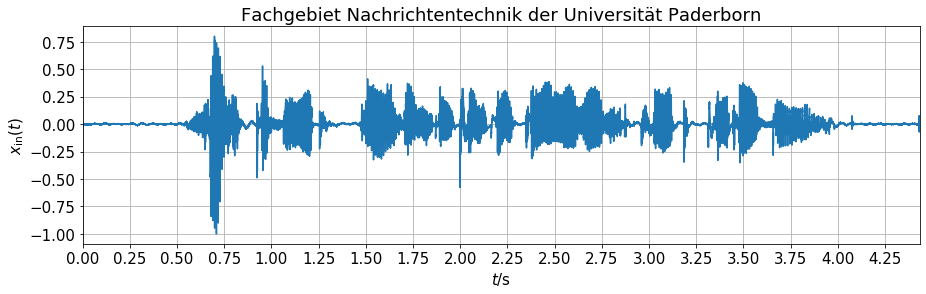

In [4]:
sample_rate, x_in = wav.read("fg_nt_upb_16k.wav")
x_in = x_in.astype(np.float)/np.abs(x_in).max()

plot_time_domain_signal(x_in, sample_rate,
                 title="Fachgebiet Nachrichtentechnik der Universität Paderborn",
                 ylabel=r'$x_\mathrm{in}(t)$')

#### Remark:

The following sections contain interactive plots with two or three parameters.

The values can be chosen as:

(N = fft_length, default = 1024
B = frame shift, default = 128)
\begin{align}
    N &= 2^{\mathrm{N\_exp}} \\
    B &= \min\left\{ 2^{\mathrm{B\_exp}}, N\right\} \\
    P_{x, \mathrm{min}} &= 10^{\frac{\mathrm{floor\_val}}{10}}\cdot P_{x, \mathrm{max}} \\
\end{align}

### Absolute Amplitude plot

If we want to view an STFT, we have to do some additional processing.
Since the STFT consists of complex coefficients for every pair of **frame**-frequency indices, plotting might be difficult. Fortunately, our primary interest lies in the Amplitude.

However, plotting the absolute amplitudes is not very helpful:

In [5]:
@interact(N_exp=IntSlider(min=5, max=10, step=1, value=9), 
          B_exp=IntSlider(min=0, max=10, step=1, value=7))
def show_abs_val(N_exp, B_exp):
    N = int(2**N_exp)
    B = min(int((2**B_exp)), N)
    X = stft(x_in, N, B)
    fft_length, num_frames = X.shape
    plt.imshow(np.abs(X[:fft_length//4+1]), origin='lower', aspect='auto');
    plt.xlabel(r'$m$', fontsize=15)
    plt.ylabel(r'$k$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    at = AnchoredText('N={N:d}\nB={B:d}'.format(N=N, B=B), 
                      prop={'size': 15}, loc=2)
    plt.gca().add_artist(at)
    plt.show()

interactive(children=(IntSlider(value=9, description='N_exp', max=10, min=5), IntSlider(value=7, description='…

## Spectrogram

Instead, the usual way to view an STFT is by plotting a two-dimensional color-coded plot where for every frame and frequency index, the absolute value of the spectral coefficient is shown in Decibels.
This performs a compression of the amplitude axis which is very natural to the human ear: The upcoming lectures will show that the perception of loudness is roughly logarithmic.

The FFT length is fixed at $1024$ samples, but the window size is variable, which results in zero padding as necessary.   

Furthermore, since zeros in the STFT would cause a floating-point error and small values would dominate the color scale, the values are floored proportional to the Maximum Value: The parameter `floor_val` is the ratio between the smallest and the largest value in Decibel.

Thus, what is actually shown is 

\begin{align}
    20\log_{10}\left( \min\left \{\frac{\left|X(k,m)\right|}{\sqrt{M}},\quad 10^{\frac{\mathrm{floor\_val}}{20}}\cdot \underset{\forall (k,m)}{ \max}\left\{\frac{\left|X(k,m)\right|}{\sqrt{M}} \right\} \right\}\right)
\end{align}

The normalization by $\sqrt{M}$ is often used because this results in a Periodogram to be shown, which is an estimate of the power spectral density:

\begin{align}
    P(k,m) = \frac{\left|X(k,m)\right|^2}{M}
\end{align}

The next plot shows the spectrogram of the example sentence. Note that the rectangular window is called `'boxcar'` in scipy. Play around with the values to see what happens. What is your perceived best choice of parameters?

In [6]:
@interact(floor_val=IntSlider(min=-120, max=0, step=6, value=-66),
          N_exp=IntSlider(min=5, max=10, step=1, value=9), 
          B_exp=IntSlider(min=0, max=10, step=1, value=7),
          window=['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett'])
def show_stft(floor_val, N_exp, B_exp, window):
    N = int(2**N_exp)
    B = min(int((2**B_exp)), N)
    X = stft(x_in, fft_length=1024, window_length=N, frame_shift=B, window=window)
    plot_stft(X, frame_shift=B, sample_rate=sample_rate, floor_val=floor_val)
    
    at = AnchoredText('N={N:d}\nB={B:d}'.format(N=N, B=B), 
                      prop={'size': 15}, loc=2)
    plt.gca().add_artist(at)
    plt.show()

interactive(children=(IntSlider(value=-66, description='floor_val', max=0, min=-120, step=6), IntSlider(value=…

## Extra Credit

In practice, spectrograms of speech signals are used e.g. by linguists, phoneticians and speech therapists.
Some people have learned to read spectrograms, i.e. they know what was said by looking at one.   
Here is a Howto that covers the basics:
[How do I read a spectrogram?](http://home.cc.umanitoba.ca/~robh/howto.html)   
and one in german:
[Das Lesen von Sonagrammen](http://www.phonetik.uni-muenchen.de/studium/skripten/SGL/SGLKap2.html)   
In these applications, a spectrogram is often combined with curves that predict the pitch frequency and the [formant frequencies](https://en.wikipedia.org/wiki/Formant) during voiced phonemes. How this can be done is covered later in the lecture (keyword **LPC**).   
   
If you want to, you can try it yourself:   

- Where do you see voiced phonemes (vocals, nasals)?
- Where are fricatives?
- What is the defining property of a plosive?

## Closing Remarks

Outside Speech Processing, spectrograms are used for many applications, e.g.:
- General Audio Processing
- Music Analysis
- Condition Monitoring
- Vibration Analysis